In [6]:
import cv2
import dlib
import imutils
import numpy as np
import tensorflow as tf
from imutils import face_utils
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from tensorflow.keras.models import load_model

In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
import tensorflow as tf
# Displayinh the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [9]:
def detect_blink(eye_img):
    pred_B = model_b.predict(eye_img, verbose=0)
    status = pred_B[0][0]
    status = status*100
    status = round(status,3)
    return  status

   
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(int)

    eye_img = img[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

def get_eyes(shape):
    (leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    left_eye = shape[leftEyeStart:leftEyeEnd]
    right_eye = shape[rightEyeStart:rightEyeEnd]
    
    return left_eye, right_eye

def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear

# load a test image, resize it, and convert it to grayscale
def load_image(path, show=False, gray_show=False):
    test_image = cv2.imread(path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    test_image = imutils.resize(test_image, width=500)
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    
    if show:
        plt.imshow(test_image)
        plt.show()
        if gray_show:
            plt.imshow(gray, cmap='gray')
            plt.show()
    return test_image, gray

def detect_faces(face_detector, gray, scale_factor, frame_num, show_multi_faces = False):
     # detect faces in the grayscale image
    multi_face = 0
    if face_detector == 'dlib':
        rects = detector(gray, 1)
        if len(rects) == 0:
            print('No face detected', frame_num)
            return False
        elif len(rects) > 1:
            print('more faces detected')
            return False
    elif face_detector == 'haar':
        detections = haar_cascade.detectMultiScale(gray, scaleFactor=scale_factor, minNeighbors=5, minSize=(150, 150), flags=cv2.CASCADE_SCALE_IMAGE)
        #Checking if there are more than 1 detected faces
        if len(detections) > 1:
            print('multiple faces', frame_num)
            multi_face = 1
            # The predicted faces are boxes (same width and height). The last two values correspond to these.
            # So by just checking which is higher, I can find the correct face. FOR SUBJECT 16 select the smallest face!
            if detections[0][2] > detections[1][2]:
                face = detections[1]
                other = detections[0]
            else:
                face = detections[0]
                other = detections[1]
            if show_multi_faces:
                print('chosen face')
                fX, fY, fW, fH = face[0],face[1], face[2], face[3]
                plt.imshow(gray[fY:fY + fH, fX:fX + fW], cmap='gray')
                plt.show()
                print('not chosen face')
                fX, fY, fW, fH = other[0], other[1], other[2], other[3]
                plt.imshow(gray[fY:fY + fH, fX:fX + fW], cmap='gray')
                plt.show()
        elif len(detections) == 1:
            face = detections[0]
            # fX, fY, fW, fH = face[0],face[1], face[2], face[3]
            # plt.imshow(gray[fY:fY + fH, fX:fX + fW], cmap='gray')
            # plt.show()
        # if no face detected
        elif len(detections) == 0:
            print('No face detected', frame_num)
            return False, 0
        fX, fY, fW, fH = face[0],face[1], face[2], face[3]    
        rects = [dlib.rectangle(fX, fY, fX + fW, fY + fH)]
    return rects, multi_face

def get_landmarks(img, gray, rects, show=False):
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        if show: 
            # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x, y, w, h)], then draw the face bounding box
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # loop over the (x, y)-coordinates for the facial landmarks and draw them on the image
            for (x, y) in shape:
                cv2.circle(img, (x, y), 2, (0, 0, 255), -1)
    if show:     
        # show the output image with the face detections + facial landmarks
        plt.imshow(img)
        plt.show()
    return shape

In [49]:
# Specify subject number and condition.
subject = 'P11407'
condition = 'normal'

Frame: 50000


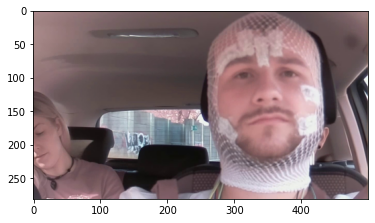

Frame: 50001


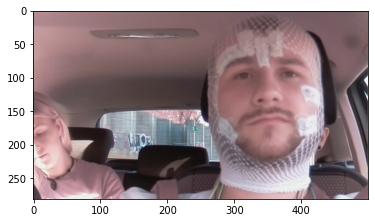

In [50]:
frame_start = 50000
frame_end = 50001

frames = range(frame_start, frame_end + 1)

# Just plotting sequence of frames
def plot_frames(frames):
    for frame in frames:
        path = '../frames/' + subject + '/' + condition + '/frame' + str(frame) + '.jpg'
        print("Frame: " + str(frame))
        test_img, gray = load_image(path, show=True, gray_show=False)
        
plot_frames(frames)

In [51]:
IMG_SIZE = (1296,730)
B_SIZE = (34, 26)

#path = '../test_frames/frame848.jpg'

# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)

# define pre-trained landmark detector path
ld_path = '../models/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(ld_path)
detector = dlib.get_frontal_face_detector()

model_b = load_model('../models/blinkdetection.h5')
face_detector = 'haar'
print('Done')

Done


In [52]:
import gc
gc.collect()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [53]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [53]:
frame_start = 80000#74000
frame_end = 81000#210000

frames = range(frame_start, frame_end + 1)

scale_factor = 1.03

folder_path = '../frames/' + subject + '/' + condition + '/frame'

# which eye openness calculation method to use: cnn or ear
eo_method = 'cnn'

def calculate_eye_openness(frames, folder_path, scale_factor, eo_method):
    status_rates = []
    wrong_frames = []
    no_face_count = 0
    multi_face_count = 0
    for frame in frames:
        if frame % 1000 == 0:
            print(frame)
        if frame % 10000 == 0:
            print("No Faces: ", no_face_count)
            print("Multi Faces: ", multi_face_count)
        if frame == 100000:
            np.save('status_rates_subject25_normal_temp.npy', status_rates)
            np.save('wrong_frames_subject25_normal_temp.npy', wrong_frames)
        path = folder_path + str(frame) + '.jpg'
        test_img, gray = load_image(path, show=False)
        rects, multi_face = detect_faces(face_detector, gray, scale_factor, frame, show_multi_faces = False)
        
        multi_face_count += multi_face
        
        if rects == False:
            no_face_count += 1
            # append eye opennes status from previous frame
            status_rates.append(status)
            wrong_frames.append(frame)
            continue
            
        shapes = get_landmarks(test_img, gray, rects, show=False)
        
        if eo_method == 'cnn':
            eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
            # eye_img_color, _ = crop_eye(test_img, eye_points=shapes[36:42])
            eye_blink_left = cv2.resize(eye_img_l.copy(), B_SIZE)
            # plt.imshow(eye_img_color)
            # plt.show()
            eye_blink_left_i = eye_blink_left.reshape((1, B_SIZE[1], B_SIZE[0], 1)).astype(np.float32) / 255.
            status = detect_blink(eye_blink_left_i)
        
        elif eo_method == 'ear':
            left_eye, right_eye = get_eyes(shapes)
            left_ear = eye_aspect_ratio(left_eye)
            right_ear = eye_aspect_ratio(right_eye)
            
            status = (left_ear + right_ear) / 2
        
        status_rates.append(status)

    print("No Faces: ", no_face_count)
    print("Multiple Faces: ", multi_face_count)
    return status_rates, wrong_frames

print('Done')
status_rates, wrong_frames = calculate_eye_openness(frames, folder_path, scale_factor, eo_method)
#np.save('status_rates_subject25_normal.npy', status_rates)
#np.save('wrong_frames_subject25_normal.npy', wrong_frames)

Done
80000
No Faces:  0
Multi Faces:  0
81000
No Faces:  0
Multiple Faces:  0


In [ ]:
plt.title("Status rate (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('Rate')
plt.plot(frames, status_rates)
plt.show()

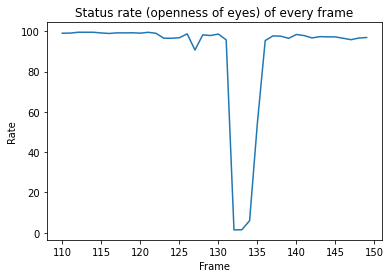

In [38]:
# look at the graph more in depth

# DONT change these parameters
frame_start = 0
frame_end = 2774  # normal sleep: last frame is 2804    restricted sleep: last frame is 2774 
frames = range(frame_start, frame_end + 1)

# CHANGE these parameter
frame_start = 110
frame_end = 150

plt.title("Status rate (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('Rate')
plt.plot(frames[frame_start:frame_end], status_rates[frame_start:frame_end])
plt.show()

In [ ]:
# Finds eye-blinks given a sequence of values and a treshhold.
def find_blinks(values, treshhold):
    blink = False
    blinks = []
    blink_count = 0
    for i, val in enumerate(values):
        if val < treshhold:
            if blink == False:
                blink_count +=1
                start = i
            blink = True
        else:
            if blink == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                blinks.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            blink = False
    return blinks, blink_count

treshhold = 15
blinks, count = find_blinks(status_rates, treshhold)
print(blinks)
print(np.array(blinks)[:,2])
print(len(blinks))

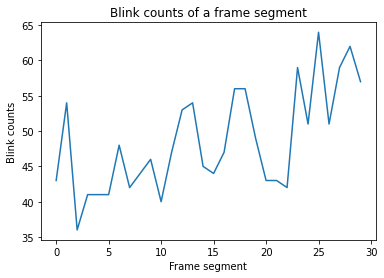

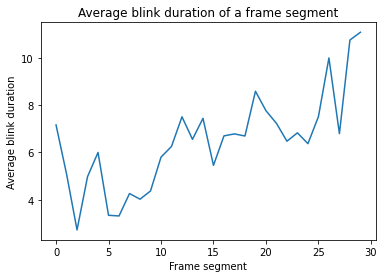

30
30


In [41]:
blink_starts = list(np.array(blinks)[:,0])
blink_durs = list(np.array(blinks)[:,2])

# Extracts features in a segment from given blinks
def blinks_segment(blink_starts, blink_durs, video_len, segment_len):
    # the amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    blink_counts = []
    average_durs = []
    
    blink_count = 0
    dur_count = 0
    
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames):
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            #print('new_segment', frame)
            blink_counts.append(blink_count)
            if dur_count > 0:
                avg_dur = dur_count / blink_count
            else:
                avg_dur = 0
            average_durs.append(avg_dur)
            blink_count = 0 
            dur_count = 0
        # happens when a blink starts
        if frame in blink_starts:
            frame_index = blink_starts.index(frame)
            blink_count += 1
            dur_count += blink_durs[frame_index]
            
    return blink_counts, average_durs
        
    
blink_counts, average_durs = blinks_segment(blink_starts, blink_durs, 83000, 2600)

# Plotting blink counts
plt.title("Blink counts of a frame segment")
plt.xlabel('Frame segment')
plt.ylabel('Blink counts')
plt.plot(range(len(blink_counts)), blink_counts)
plt.show()

# Plotting average blink durations
plt.title("Average blink duration of a frame segment")
plt.xlabel('Frame segment')
plt.ylabel('Average blink duration')
plt.plot(range(len(average_durs)), average_durs)
plt.show()

print(len(blink_counts))
print(len(average_durs))